# Compete and collaborate. 
## Tennis enviroment.

In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
#local test 
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")
#udacity enviroment
#env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
import random
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import time
from model import Network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### Learning Algorithm
We are goinng to use shared Replay buffer and Ornstein–Uhlenbeck noise generation on multi agent deep deterministic policy gradient, that is a multi agent actor critic method.
We are using similar Architecture for both actor and critic, and all in one Network, 200 units on first hidden layer and 150 units on second hidden layers and an actor-critic variable to define the type. For our actor,the input is our state size and out input is the action space all fully connected uing relu and a tanh in the last layer. While the critic inputs state size and action size for both agents and output one unit only. 3 fully connected layers with 2 relu in the beginning and no activation in the last layer.

Hyperparameters are as follows, we are not using Grad_clipping, epsilon and epsilon decay. Tau used on soft update. I have not place here learning number and learning every on the step for learning using 10 and 20 respectively (below cells for the implementation):

In [6]:
BUFFER_SIZE = int(1e5)   # replay buffer size
BATCH_SIZE = 250         # minibatch size
GAMMA = 0.99             # discount factor
TAU = 1e-3               # for soft update of target parameters
LR_ACTOR = 1e-4          # learning rate of the actor
LR_CRITIC = 1e-3         # learning rate of the critic 2539
WEIGHT_DECAY = 0.0       # L2 weight decay
GRAD_CLIPPING = 1.0
EPSILON = 1.0  
EPSILON_DECAY = 1e-6

In [7]:
! cat model.py

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def hidden_init(layer):
    """Xavier weight inizialization: http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf
    Initizaling weights from a uniform distribution and scaling them"""
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Network(nn.Module):
    def __init__(self, state_size, action_size, fc1_units=200, fc2_units=150, actor=False):
        super(Network, self).__init__()

        self.seed = torch.manual_seed(12)
        self.actor = actor
        if self.actor:
            self.fc1 = nn.Linear(state_size, fc1_units)
        else:
            self.fc1 = nn.Linear((state_size+action_size) * 2, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        if self.actor:
            self.fc3 = nn.Linear(fc2_units, action_size)
        else:
            self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def 

In [8]:
class ReplayBuffer:
    """Store experience tuples."""
    
    def __init__(self, buffer_size, batch_size, seed = 12):
        #Deque (Doubly Ended Queue)
        self.memory = deque(maxlen=buffer_size) 
        #size of each training
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names = ["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
    def add(self, state, action, reward, next_state, done):
        """Add new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        """Random sample of batch from replay buffer"""
        experiences =  random.sample(self.memory, k=self.batch_size)
        
        #vstack: Stack arrays in sequence vertically (row wise)
        states = [torch.from_numpy(np.vstack([e.state[index] for e in experiences if e is not None])).float().to(device) for index in range(num_agents)]
        actions = [torch.from_numpy(np.vstack([e.action[index] for e in experiences if e is not None])).float().to(device) for index in range(num_agents)]
        next_states = [torch.from_numpy(np.vstack([e.next_state[index] for e in experiences if e is not None])).float().to(device) for index in range(num_agents)]            
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)        
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        """"Size of internal memory"""
        return len(self.memory)

In [9]:
#defining replay buffer outside, so that it can be used by both
shared_replay_buffer = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)

In [10]:
class OUNoise:
    """Ornstein–Uhlenbeck is a mathematical stochastic process, originally from physics. 
        It is a stationary Gaussian and Markov process. We use it to add noise to the action output"""

    def __init__(self, action_dimension, mu=0, theta=0.15, sigma=0.2):
        self.seed = random.seed(12)
        self.action_dimension = action_dimension
        self.mu = np.ones(self.action_dimension) * mu 
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dimension) * self.mu

    def noise(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state

class Agent():
    
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = EPSILON
        
        #from model.py
        self.actor = Network(state_size, action_size, actor= True).to(device)
        self.actor_target = Network(state_size, action_size, actor = True).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(),lr=LR_ACTOR)

        self.critic = Network(state_size, action_size, actor = False).to(device)
        self.critic_target = Network(state_size, action_size, actor = False).to(device)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # noise processing
        self.noise = OUNoise(action_size)
        
    def soft_update(self, target, source, tau):
        """
        Perform DDPG soft update (move target params toward source based on weight factor tau)
        Inputs:
        target (torch.nn.Module): Net to copy parameters to
        source (torch.nn.Module): Net whose parameters to copy
        tau (float, 0 < x < 1): Weight factor for update
        """
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)
            
    def step(self, timestep):
        """Save experience in replay buffer, and use sample from buffer to learn: From double-jointed arm.
            Add timestep"""
        #use the following, slower to train, faster at each episode
        #learning timestep interval is equal to 20
        if len(shared_replay_buffer) > BATCH_SIZE and timestep % 20 == 0:
            #number of learning passes
            for _ in range(10):
                experiences = shared_replay_buffer.sample()
                self.learn(experiences, GAMMA) 
    
        #if len(shared_replay_buffer) > BATCH_SIZE:
        #    experiences = shared_replay_buffer.sample()
        #    self.learn(experiences, GAMMA)        

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor.eval()
        with torch.no_grad():
            action = self.actor(state).cpu().data.numpy()
        self.actor.train()
        if add_noise:
            action += self.noise.noise() # * self.epsilon
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """
        Experience is a tuple of states, actions, rewards, next_states, dones
        Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        """
        states, actions, rewards, next_states, dones = experiences
                    
        #to tensors, otherwise errors
        next_states_tensor = torch.cat(next_states, dim=1).to(device)
        states_tensor = torch.cat(states, dim=1).to(device)
        actions_tensor = torch.cat(actions, dim=1).to(device)
        
        # use target models
        next_actions = [self.actor_target(states) for states in states]        
        next_actions_tensor = torch.cat(next_actions, dim=1).to(device)  
        #to feed critic we use actor actions
        Q_targets_next = self.critic_target(next_states_tensor, next_actions_tensor)        
        #Compute Q targets 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))        
        #critic loss
        Q_expected = self.critic(states_tensor, actions_tensor)
        critic_loss = F.mse_loss(Q_expected, Q_targets)        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        #if GRAD_CLIPPING > 0:
        #    torch.nn.utils.clip_grad_norm_(self.critic.parameters(), GRAD_CLIPPING)
        self.critic_optimizer.step()

        #actor
        actions_pred = [self.actor(states) for states in states]        
        actions_pred_tensor = torch.cat(actions_pred, dim=1).to(device)
        actor_loss = -self.critic(states_tensor, actions_pred_tensor).mean()        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()        
        self.actor_optimizer.step()

        #soft update
        self.soft_update(self.critic_target, self.critic, TAU)
        self.soft_update(self.actor_target, self.actor, TAU)
        #if EPSILON_DECAY > 0:
        #    self.epsilon -= EPSILON_DECAY
        #    self.noise.reset()

In [11]:
class MADDPG:
    """Implementation of Multi agent Deep Deterministic Policy Gradient"""

    def __init__(self):
        self.agents = [Agent(state_size,action_size) for x in range(num_agents)]

    #add timestep if needed
    def step(self, states, actions, rewards, next_states, dones, timestep):
        shared_replay_buffer.add(states, actions, rewards, next_states, dones)

        for agent in self.agents:
            agent.step(timestep)
    
    def act(self, obs_all_agents, add_noise=True):
        """get actions from all agents in the MADDPG object"""
        actions = [agent.act(obs, add_noise) for agent, obs in zip(self.agents, obs_all_agents)]
        return actions

    
    def reset(self):        
        for agent in self.agents:
            agent.reset()

In [13]:
maddpg = MADDPG() 

scores_deque = deque(maxlen=100)
scores = []
average_scores_list = []

for episode in range(1, 10000):                                    
    env_info = env.reset(train_mode=True)[brain_name]     
    states = env_info.vector_observations               
    score = np.zeros(num_agents)

    maddpg.reset()

    start_time = time.time()
    for t in range(1000):
        #for the following implementation add timestep variable as in double-jointed arm
        #while True:
        actions = maddpg.act(states)
        env_info = env.step(actions)[brain_name]            
        next_states = env_info.vector_observations
        rewards = env_info.rewards         
        dones = env_info.local_done                         
        maddpg.step(states, actions, rewards, next_states, dones, t)        
        states = next_states
        score += rewards  

        if any(dones):                                 
            break

    end_time = time.time()
    duration = end_time - start_time
    
    score_max = np.max(score)
    scores.append(score_max)
    scores_deque.append(score_max)
    average_score = np.mean(scores_deque)
    average_scores_list.append(average_score)

    print('\rEpisode {}\tAverage Score: {:.3f}'.format(episode, np.mean(scores_deque)), end="")  

    if episode % 100 == 0:
        print('\rEpisode {}({}s)\tAverage score: {:.3f}'.format(episode, round(duration), average_score))

    if average_score >= 0.5:
        for index, agent in enumerate(maddpg.agents):
            torch.save(agent.actor.state_dict(), 'agent{}_checkpoint_actor.pth'.format(index+1))
            torch.save(agent.critic.state_dict(), 'agent{}_checkpoint_critic.pth'.format(index+1))
        print("\rSolved in episode: {} \tAverage score: {:.3f}".format(episode , average_score))
        break

Episode 100(0s)	Average score: 0.000
Episode 200(0s)	Average score: 0.000
Episode 300(0s)	Average score: 0.000
Episode 400(0s)	Average score: 0.000
Episode 500(0s)	Average score: 0.001
Episode 600(0s)	Average score: 0.001
Episode 700(0s)	Average score: 0.004
Episode 800(0s)	Average score: 0.003
Episode 900(0s)	Average score: 0.019
Episode 1000(1s)	Average score: 0.033
Episode 1100(1s)	Average score: 0.064
Episode 1200(1s)	Average score: 0.095
Episode 1300(2s)	Average score: 0.137
Episode 1400(3s)	Average score: 0.237
Episode 1500(0s)	Average score: 0.415
Solved in episode: 1581 	Average score: 0.500


#### It took 1581 episodes to solve the tennis problem

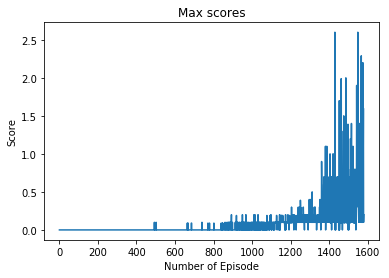

In [16]:
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Number of Episode')
plt.title("Max scores")
plt.show()

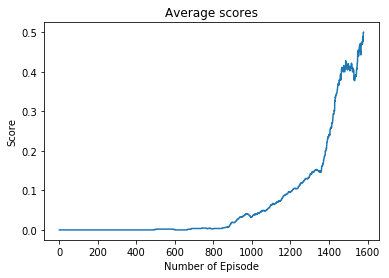

In [18]:
plt.plot(np.arange(len(average_scores_list)), average_scores_list)
plt.ylabel('Score')
plt.xlabel('Number of Episode')
plt.title("Average scores")
plt.show()

In [20]:
#close the enviroment
#env.close()

### Ideas for future work
When making this project I tested different hyperparameters both RL specific and neural network hyperparameters and I found that really important, for example the discount factor and even the seed.In tested different amount of units, ranging from 150 to 200 on the second hidden layer and 250 to 350 on the first, keeping the former value for both. <br>
The are other multi agent algorithms such as multi agent DQN and multi agent PPO. Remember that PPO is a proximal policy optimization technique that uses stochastic gradient descent over a sample dataset. For example implementation visit this [repository](https://github.com/jsztompka/MultiAgent-PPO). <br>
Definetly I do not recommend using **gradient clipping** with this particular architecture, since I found it not useful at all. Also, implementing learning every time instead on learning every defined timestep, however I found the latter faster on every episode but slower to reach the goal.<br>
I would say big changes might come from Network architecture according to Josh Tobin on [Full Stack Deep Learning](https://fullstackdeeplearning.com/) normalizing the layers might be a good idea, as well as testing different activation functions, since I just used relu and tanh. Also, try different Learning rates mine range from 0.01 to 0.00001.
From replay buffer, instead of normal sampling method, implement **prioritized experience replay**.<br>
It also might be interesting to implement DDGP, TRPO (Trust Region Policy Optimization) or A3C (Asynchronous Actor-Critic), however multi-agent methods might perform better.

## Test our agents!

In [22]:
maddpg = MADDPG() 

In [23]:
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'

maddpg.agents[0].actor.load_state_dict(torch.load('agent1_checkpoint_actor.pth', map_location=map_location))
maddpg.agents[1].actor.load_state_dict(torch.load('agent2_checkpoint_actor.pth', map_location=map_location))

In [24]:
env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations  # get the current states
maddpg.reset()
for _ in range(4):
    for t in range(3000):
        actions = maddpg.act(states)                   # let the agent select actions (don't add noise)
        env_info = env.step(actions)[brain_name]      # execute the selected actions and save the new information about the environment
        next_states = env_info.vector_observations    # get the resulting states
        dones = env_info.local_done                   # check whether episodes have finished
        states = next_states
        if np.any(dones):
            break 

In [25]:
env.close()